Dummy GPT Model class

In [ ]:
import torch.nn as nn
import torch

In [ ]:
GPT_CONFIG_124M = {
    'context_length': 1024,
    'vocab_size': 50257,
    'emb_dim': 768,
    'n_heads': 12, # attention heads
    'n_layers': 12, # num of transformer layers
    'drop_rate': 0.1,
    'qvk_bias': False
}

In [ ]:
class Dummy_gpt_model(nn.Module):

  def __init__(self,cfg):
    super()._init__()
    self.token_embedding=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_embedding=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.dropout= nn.Dropout(cfg['drop_rate'])

    self.trf_block= nn.Sequential(*[Dummy_Transformer_block(cfg) for _ in cfg['n_layers']])
    self.final_Norm= Dummy_Layer_Norm(cfg['emb_dim'])
    self.out_head= nn.Linear(cfg['emb_dim'],cfg['vocab_size'], bias=False)



  def forward(self,in_idx):
    batch_size,seq_len=in_idx.shape
    token_emb=self.token_embedding(in_idx)
    pos_emb=self.pos_embedding(torch.arange(seq_len,device=in_idx.device))
    x=token_emb + pos_emb
    x=self.dropout(x)
    x=self.trf_block()
    x=self.final_Norm()
    logits= self.out_head()

    return logits



class Dummy_Transformer_block(nn.Module):

  def __init__(self,cfg):
    super()._init__()

  def forward(self,x):
    return x

class Dummy_Layer_Norm(nn.Module):

  def __init__(self,normalized_shape,eps=1e-5):
    super()._init__()

  def forward(self,x):
    return x


Implementing Layer Normalization

In [ ]:
class LayerNorm(nn.Module):

  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean= x.mean(dim=-1, keepdim=True)
    var= x.var(dim=-1, keepdim=True,unbiased=False)
    norm_x=(x-mean)/(torch.sqrt(var)+self.eps)

    return self.scale * norm_x + self.shift


In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
ln=LayerNorm(emb_dim=5)
normalized_batch=ln(batch_example)
print("Normalized Batch: ", normalized_batch,'\n')
torch.set_printoptions(sci_mode=False)
print('Mean: ', normalized_batch.mean(dim=-1, keepdim=True),'\n')
print('Variance: ', normalized_batch.var(dim=-1,unbiased=False, keepdim=True),'\n')

Normalized Batch:  tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>) 

Mean:  tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>) 

Variance:  tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>) 



Implementing Feed Forward Layer:  linear -> GELU -> linear

In [ ]:
class GELU(nn.Module): # GELU activation Function

  def __init__(self):
    super().__init__()

  def forward(self,x):
    return  0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2/torch.pi)) *
     (x + 0.044715 * torch.pow(x,3))))



class FeedForward(nn.Module):

  def __init__(self,cfg):
    super().__init__()
    self.layers= nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']), #Expansion
        GELU(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim']), #Contraction
    )

  def forward(self,x):
    return self.layers(x)

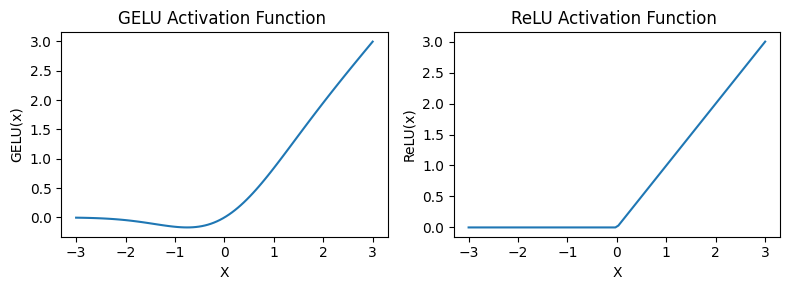

In [ ]:
import matplotlib.pyplot as plt


gelu , relu = GELU(), nn.ReLU()
x= torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x) , relu(x)

plt.figure(figsize=(8,3))
for i , (label,y) in enumerate(zip(['GELU','ReLU'],[y_gelu,y_relu]),1):
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f'{label} Activation Function ')
  plt.xlabel('X')
  plt.ylabel(f'{label}(x)')
  plt.grid=True

plt.tight_layout()
plt.show()



In [ ]:
x = torch.rand(2, 3, 768)
ff=FeedForward(GPT_CONFIG_124M)
output=ff(x)
print(output.shape)



torch.Size([2, 3, 768])


Shortcut Connections

In [ ]:
class DeepNeuralNetwork(nn.Module):

  def __init__(self,shortcut,layer_size):
    super().__init__()
    self.shortcut=shortcut
    self.layers= nn.ModuleList([
        nn.Sequential(nn.Linear(layer_size[0],layer_size[1]), GELU()),
        nn.Sequential(nn.Linear(layer_size[1],layer_size[2]), GELU()),
        nn.Sequential(nn.Linear(layer_size[2],layer_size[3]), GELU()),
        nn.Sequential(nn.Linear(layer_size[3],layer_size[4]), GELU()),
        nn.Sequential(nn.Linear(layer_size[4],layer_size[5]), GELU())
    ])

  def forward(self,x):

    for layer in self.layers:
      layer_output= layer(x)

      if self.shortcut and x.shape==layer_output.shape:
        x=x+ layer_output
      else:
        x=layer_output

    return x

In [ ]:
layer_size=[3,3,3,3,3,2]
x=torch.tensor([[1., 0., -1.]])
shortcut_false_obj=DeepNeuralNetwork(False,layer_size)
shortcut_false=shortcut_false_obj(x)
print(shortcut_false)
print(shortcut_false.shape)

tensor([[ 0.1222, -0.0813]], grad_fn=<MulBackward0>)
torch.Size([1, 2])


In [ ]:
shortcut_True_obj=DeepNeuralNetwork(True,layer_size)
shortcut_True=shortcut_True_obj(x)
print(shortcut_True)
print(shortcut_True.shape)

tensor([[ 0.1027, -0.0977]], grad_fn=<MulBackward0>)
torch.Size([1, 2])


In [ ]:
def print_gradients(model,x):

  output=model(x)
  target=torch.tensor([[0.0]])

  loss=nn.MSELoss()
  loss=loss(output,target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:

      print(f"{name} has a gradient mean of {param.grad.abs().mean().item()}")



In [ ]:
print_gradients(shortcut_false_obj,x)

layers.0.0.weight has a gradient mean of 8.47608462208882e-05
layers.1.0.weight has a gradient mean of 4.295782127883285e-05
layers.2.0.weight has a gradient mean of 0.0003524677886161953
layers.3.0.weight has a gradient mean of 0.0015995483845472336
layers.4.0.weight has a gradient mean of 0.006056517828255892


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
print_gradients(shortcut_True_obj,x)

layers.0.0.weight has a gradient mean of 0.0037773335352540016
layers.1.0.weight has a gradient mean of 0.007775923237204552
layers.2.0.weight has a gradient mean of 0.010132890194654465
layers.3.0.weight has a gradient mean of 0.013051428832113743
layers.4.0.weight has a gradient mean of 0.058111872524023056


Entire LLM Transformer Block

In [ ]:
class Multi_head_attention(nn.Module):

  def __init__(self,d_in,d_out,dropout,num_heads,context_length, qvk_bias=False):
    super().__init__()

    assert(d_out%num_heads==0) ,\
          "d_out must be divisible by num_heads"

    self.d_out=d_out
    self.num_heads=num_heads
    self.head_dim=d_out//num_heads
    self.query=nn.Linear(d_in,d_out,bias=qvk_bias)
    self.key=nn.Linear(d_in,d_out,bias=qvk_bias)
    self.value=nn.Linear(d_in,d_out,bias=qvk_bias)
    self.out_proj=nn.Linear(d_out,d_out)  #Linear layer to combine head outputs
    self.dropout=nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones((context_length,context_length)), diagonal=1))


  def forward(self,x):
    b,n_tokens,d_in=x.shape
    query1=self.query(x)
    key1=self.key(x)
    value1=self.value(x)

    # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
    query1=query1.view(b,n_tokens,self.num_heads, self.head_dim)
    key1=key1.view(b,n_tokens,self.num_heads, self.head_dim)
    value1=value1.view(b,n_tokens,self.num_heads, self.head_dim)

    # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
    query1=query1.transpose(1,2)
    key1=key1.transpose(1,2)
    value1=value1.transpose(1,2)

    attn_scores=query1 @ key1.transpose(2,3)
    attn_scores.masked_fill_(self.mask.bool()[:n_tokens,:n_tokens] , -torch.inf)

    attn_weights=torch.softmax(attn_scores/key1.shape[-1]**0.5,dim=-1)
    attn_weights=self.dropout(attn_weights)

    # Shape: (b, num_tokens, num_heads, head_dim)
    cntxt_vctr=(attn_weights @ value1).transpose(1,2)
    # Combine heads, where self.d_out = self.num_heads * self.head_dim
    cntxt_vctr=cntxt_vctr.contiguous().view(b,n_tokens,self.d_out)
    cntxt_vctr=self.out_proj(cntxt_vctr)

    return cntxt_vctr




In [ ]:
class TransformerBlock(nn.Module):

  def __init__(self,cfg):
    super().__init__()
    self.attention=Multi_head_attention(
        d_in=cfg['emb_dim'],
        d_out=cfg['emb_dim'],
        dropout=cfg['drop_rate'],
        num_heads=cfg['n_heads'],
        context_length=cfg['context_length'],
        qvk_bias=cfg["qvk_bias"]
        )
    self.norm1=LayerNorm(cfg['emb_dim'])
    self.norm2=LayerNorm(cfg['emb_dim'])
    self.dropout_layer=nn.Dropout(cfg['drop_rate'])
    self.feed_forward=FeedForward(cfg)


  def forward(self,x):

    shortcut=x
    x=self.norm1(x)
    x=self.attention(x)
    x=self.dropout_layer(x)
    x= x+ shortcut

    shortcut = x
    x=self.norm2(x)
    x=self.feed_forward(x)
    x=self.dropout_layer(x)
    x= x+ shortcut

    return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block_obj= TransformerBlock(GPT_CONFIG_124M)
block_output=block_obj(x)
print('Input shape: ',x.shape)
print('Output shape: ',block_output.shape)

Input shape:  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])


Entire GPT Model Architecture Implementation

In [ ]:
class gpt_model(nn.Module):

  def __init__(self,cfg):
    super().__init__()
    self.token_embedding=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_embedding=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.dropout= nn.Dropout(cfg['drop_rate'])

    self.trf_block= nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_Norm= LayerNorm(cfg['emb_dim'])
    self.out_head= nn.Linear(cfg['emb_dim'],cfg['vocab_size'], bias=False)



  def forward(self,in_idx):
    batch_size,seq_len=in_idx.shape
    token_emb=self.token_embedding(in_idx)
    pos_emb=self.pos_embedding(torch.arange(seq_len,device=in_idx.device))
    x=token_emb + pos_emb
    x=self.dropout(x)
    x=self.trf_block(x)
    x=self.final_Norm(x)
    logits= self.out_head(x)

    return logits

In [ ]:
torch.manual_seed(123)
gpt_model_obj=gpt_model(GPT_CONFIG_124M)
batch=torch.tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
out=gpt_model_obj(batch)
print(batch.shape)
print(out.shape)

torch.Size([2, 4])
torch.Size([2, 4, 50257])


In [ ]:
total_params= sum(prm.numel() for prm in gpt_model_obj.parameters())
print("total parameters in our gpt model : ",f'{total_params:,}')

total parameters in our gpt model :  163,009,536


In [ ]:
#but gpt2 has 124M parameter why does our model has 163M? bcz in gpt2, they are reusing the weights of token embedding layer
#in the linear output layer , this is called weight tying

In [ ]:
print('token embedding weight shape: ', gpt_model_obj.token_embedding.weight.shape)
print('Output layer weight shape: ',gpt_model_obj.out_head.weight.shape)

token embedding weight shape:  torch.Size([50257, 768])
Output layer weight shape:  torch.Size([50257, 768])


In [ ]:
#As we can see both have same number of shapes

In [ ]:
total_bytes=total_params*4
total_bytes_MB=total_bytes/(1024*1024)
print('Total size of our model: ',f'{total_bytes_MB:.2f}','MB')

Total size of our model:  621.83 MB


Generating Text from the output tokens

In [ ]:
class generate_text_simple(nn.Module):

  def __init__(self,cfg):
    super().__init__()

  def forward(self,model,idx,context_size,max_new_length):

    for _ in range(max_new_length):
      idx_cond=idx[:,-context_size:]

      with torch.no_grad():
        logits=model(idx_cond)

      logits=logits[:,-1,:]
      probs=torch.softmax(logits, dim=-1)
      idx_next=torch.argmax(probs, dim=-1, keepdim=True)

      idx= torch.cat((idx,idx_next), dim=-1)

    return idx


In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00


In [ ]:
import tiktoken
tokenizer=tiktoken.get_encoding('gpt2')
text=' Hello , I am'
encoded=tokenizer.encode(text)
print(encoded)
encoded_tensor= torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor)

[18435, 837, 314, 716]
tensor([[18435,   837,   314,   716]])


In [ ]:
gpt_model_obj.eval()
generator=generate_text_simple(GPT_CONFIG_124M)
out=generator(model=gpt_model_obj,idx=encoded_tensor,context_size=GPT_CONFIG_124M['context_length'],max_new_length=6)

print('Output: ',out)


Output:  tensor([[18435,   837,   314,   716, 46895, 36274, 37195, 26455,  6613, 13918]])


In [ ]:
tokenizer.decode(out.squeeze(0).tolist())

' Hello , I am pedigreeigor AUTH Sith proudEXT'

In [ ]:
# Now this prediction has been made by the random weights.

In [ ]:
def text_to_tokenId(text, tokenizer):
  encoded=tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor=torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor


def tokenId_to_text(token_ids,tokenizer):
  flat=token_ids.squeeze(0)
  decoded=tokenizer.decode(flat.tolist())
  return decoded


text="You cannot fail, "
tokenizer=tiktoken.get_encoding('gpt2')
model=generate_text_simple(GPT_CONFIG_124M)
token_ids=model(model=gpt_model_obj,
          idx=text_to_tokenId(text,tokenizer),
          context_size=GPT_CONFIG_124M['context_length'],
          max_new_length=10)

print('Output: ',tokenId_to_text(token_ids,tokenizer))

Output:  You cannot fail, iman Byeswick GH Spirit Disclosure paranoiaelve ChalLinux


Calculating the text generation loss: cross-entropy and perplexity

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [ ]:
torch.manual_seed(123)
model=gpt_model(GPT_CONFIG_124M)
with torch.no_grad():
  logits=model(inputs)

print("Logits shape: ",logits.shape)

Logits shape:  torch.Size([2, 3, 50257])


In [ ]:
probas=torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [ ]:
predicted_output=torch.argmax(probas, dim=-1)
print(predicted_output.shape)
print(predicted_output)

torch.Size([2, 3])
tensor([[23799,  2662, 12752],
        [20522, 49289, 17284]])


In [ ]:
# ([[3626, 6100, 345  ],
# [1107,  588, 11311]])

#Now, the predicted output results are quite far away from target.

In [ ]:
text_id0=0
target_prob1=probas[text_id0,[0,1,2], targets[text_id0]]
text_id1=1
target_prob2=probas[text_id1,[0,1,2], targets[text_id1]]

print(target_prob1,'\n')
print(target_prob2,'\n')


tensor([    0.0000,     0.0000,     0.0000]) 

tensor([    0.0000,     0.0000,     0.0000]) 



In [ ]:
#Above these probabilites should be equal to 1
target_probs=torch.cat([target_prob1,target_prob2])
print(target_probs.shape)
print(target_probs)

torch.Size([6])
tensor([    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000])


In [ ]:
log_targets=torch.log(target_probs)
print(log_targets)

tensor([-10.5874, -10.5089, -11.1218, -10.3691, -11.4307, -11.9483])


In [ ]:
mean_log_targets=torch.mean(log_targets,dim=-1)
print(mean_log_targets)

tensor(-10.9944)


In [ ]:
neg_log_probs=mean_log_targets*-1
print(neg_log_probs)

tensor(10.9944)


In [ ]:
#Now calculating the cross entropy loss by using the built in function
logits_flat=logits.flatten(0,1)
targets_flat=targets.flatten()
print(logits_flat.shape)
print(targets_flat.shape)

torch.Size([6, 50257])
torch.Size([6])


In [ ]:
loss=torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.9944)


Perplexity

In [ ]:
perplexity=torch.exp(loss)
print(perplexity)

tensor(59538.5938)
